Effective potential is a concept used in both physics and finance to describe the behavior of a system. 
- In physics, effective potential refers to the energy a particle experiences due to the forces acting upon it in a specific environment.
- This potential is often used to study the motion of celestial objects, such as planets, in gravitational fields.
- In finance, effective potential refers to the expected rate of return on an investment adjusted for risk. 
- This potential is often used to assess the value of different investment options and to make informed decisions about portfolio management.
- While the specific applications may differ, the concept of effective potential is fundamental to both fields and plays a crucial role in understanding the behavior of complex systems.

In [8]:
# Importing Dependencies.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
##########################
import pandas as pd
import numpy as np
#########################
from scipy import stats
#########################
import cufflinks as cf
cf.go_offline()
#########################
import datetime as dt
from datetime import timedelta
##########################
import matplotlib.pyplot as plt
import pyfolio as pf
import empyrical as ep

In [9]:
from tvDatafeed import TvDatafeed, Interval
##########################################
username = ''
password = ''
##########################################
tv = TvDatafeed(username, password)
# NIFTY INDEX.
Nifty_index_data = tv.get_hist(symbol='NIFTY',
                                    exchange='NSE',
                                    interval=Interval.in_3_minute,
                                    n_bars=20000)
Nifty_index_data = df = Nifty_index_data[['symbol','open','high','low','close','volume']]
df = df.drop(columns='volume',axis=1)
#df = df.between_time('9:15', '15:00')

ERROR:tvDatafeed.main:error while signin


In [10]:
# Define the Effective Potential function
def effective_potential(high, low, close, open):
    return (abs(high - close) + (high - low) / 4 + abs(close - open) / 3)**2

# Define the backtest function
def backtest():
    # Retrieve historical stock data
    stock_data = df
    
    # Calculate the Effective Potential
    stock_data["Effective Potential"] = effective_potential(stock_data["high"], stock_data["low"], stock_data["close"], stock_data["open"])
    
    # Define the trading strategy
    stock_data["Signal"] = np.nan
    stock_data.loc[(stock_data["Effective Potential"] > stock_data["Effective Potential"].rolling(15).mean()) , "Signal"] = 1
    stock_data.loc[(stock_data["Effective Potential"] < stock_data["Effective Potential"].rolling(15).mean()) , "Signal"] = -1

    #stock_data['Signal'] = stock_data['Signal'].where(stock_data['Signal'].diff().fillna(0).ne(0), np.nan)
    stock_data['Signal'] = stock_data['Signal'].replace(to_replace=0,method='ffill')

    # Calculate the returns
    stock_data["Returns"] = stock_data["close"].pct_change() * stock_data["Signal"].shift(1)

    # Calculate the cumulative returns
    stock_data["Cumulative Returns"] = (stock_data["Returns"]).cumsum()
    
    # Print the final cumulative returns
    print(f"Final cumulative returns for {df['symbol'][-1]}: {stock_data['Cumulative Returns'][-1]}")
    
    # Plot the cumulative returns
    stock_data["Cumulative Returns"].iplot()#(figsize=(10, 6))
    
backtest()


Final cumulative returns for NSE:NIFTY: -0.017429610850026478


Start: 
2023-08-28 09:15:00 
End: 
2023-10-30 15:00:00
------------------------
Sortino Ratio: -0.14
Calmar Ratio: -0.03
Omega Ratio: 0.98
Tail Ratio: 1.06
------------------------------
The Annualised Sharpe Ratio is -0.11
------------------------------
Total Signal Counts:
Signal
-1.0    3449
 1.0    1525
Name: count, dtype: int64
------------------------
Strategy Return: -1.74 %
Gains in Points: -340.10
The Max Drawdown: -3.32 %
Stability of Time Series: 0.04


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.32,2023-08-28,2023-09-12,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


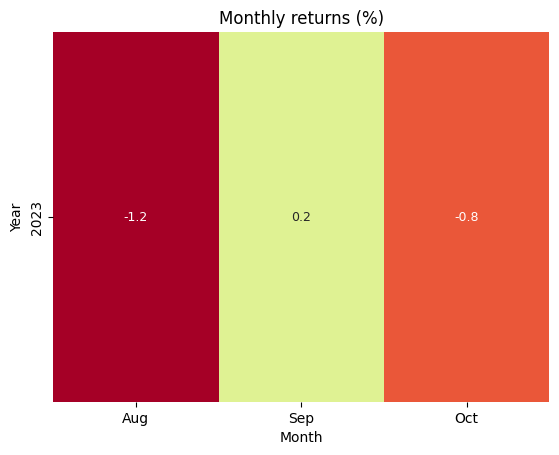

In [11]:
def metrics():
# Importing Required Dependencies.
    import numpy as np
    import pandas as pd
    import empyrical as ep
    import pyfolio as pf
# This code calculate the gains in points based on a signal column 
    j = df.Signal  # forward-fill missing values in df.position
    e = df.close

    result = []
    for i in range(len(j)):
        if i == len(j)-1 or pd.isna(j[i]) or pd.isna(j[i+1]):
            result.append(0)  # if there's a missing value or last row, append 0
        elif j[i] == -1:
            result.append(e[i] - e[i+1])
        elif j[i] == 1:
            result.append(e[i+1] - e[i])
        else:
            result.append(0)

    total = sum(result)

# Calculate the annualised Sharpe ratio
    sharpe = np.sqrt(252) * \
    df.Returns.mean() / df.Returns.std()
# Calculating Max Drawdown.
    max_dd= ep.max_drawdown(df.Returns)
# Calculating Stablity of Time Series of Returns.
    stablity = ep.stability_of_timeseries(df.Returns)
# Calculating Sortino Ratio
    Sortino = ep.sortino_ratio(df.Returns)
# Calculating Calmar ratio
    calmar_ratio = ep.calmar_ratio(df.Returns)
# Calculating Omega ratio
    omega_ratio = ep.omega_ratio(df.Returns, risk_free=0)
# Print start and end date of returns series
    print(f'Start: \n{df.index[0]} \nEnd: \n{df.index[-1]}')
    print('------------------------')
# Print various performance metrics
    print(f'Sortino Ratio: {(Sortino):.2f}') 
    print(f'Calmar Ratio: {calmar_ratio:.2f}')
    print(f'Omega Ratio: {omega_ratio:.2f}')
    print('Tail Ratio:',ep.tail_ratio(df['Returns']).round(2))
    print('------------------------------')
    print("The Annualised Sharpe Ratio is %.2f" % sharpe)
    print('------------------------------')
    print(f'Total Signal Counts:\n{df.Signal.value_counts()}')
    print('------------------------')
    print(f'Strategy Return: {((df.Returns.cumsum()[-1]*100)) :.2f} %') 
    print(f'Gains in Points: {total:.2f}')
    print(f'The Max Drawdown: {(max_dd*100):.2f} %') #times 100
    print(f'Stability of Time Series: {stablity:.2f}')
# Plot worst drawdown periods and monthly returns heatmap
    pf.show_worst_drawdown_periods(df['Returns'])
    pf.plot_monthly_returns_heatmap(df['Returns'])

metrics()

df['Signal'] = df['Signal'].where(df['Signal'].diff().fillna(0).ne(0), np.nan)

df['Signal'].value_counts()

In [12]:
j = df.Signal  # forward-fill missing values in df.position
e = df.close

result = []
for i in range(len(j)):
    if i == len(j)-1 or pd.isna(j[i]) or pd.isna(j[i+1]):
        result.append(0)  # if there's a missing value or last row, append 0
    elif j[i] == -1:
        result.append(e[i] - e[i+1])
    elif j[i] == 1:
        result.append(e[i+1] - e[i])
    else:
        result.append(0)

total = sum(result)
print(f'Gains in Points: {total:.2f}')

Gains in Points: -340.10


Start date,2023-08-28
End date,2023-10-30
Total months,237
,Backtest
Annual return,-0.091%
Cumulative returns,-1.792%
Annual volatility,0.815%
Sharpe ratio,-0.11
Calmar ratio,-0.03
Stability,0.04
Max drawdown,-3.321%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.32,2023-08-28,2023-09-12,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


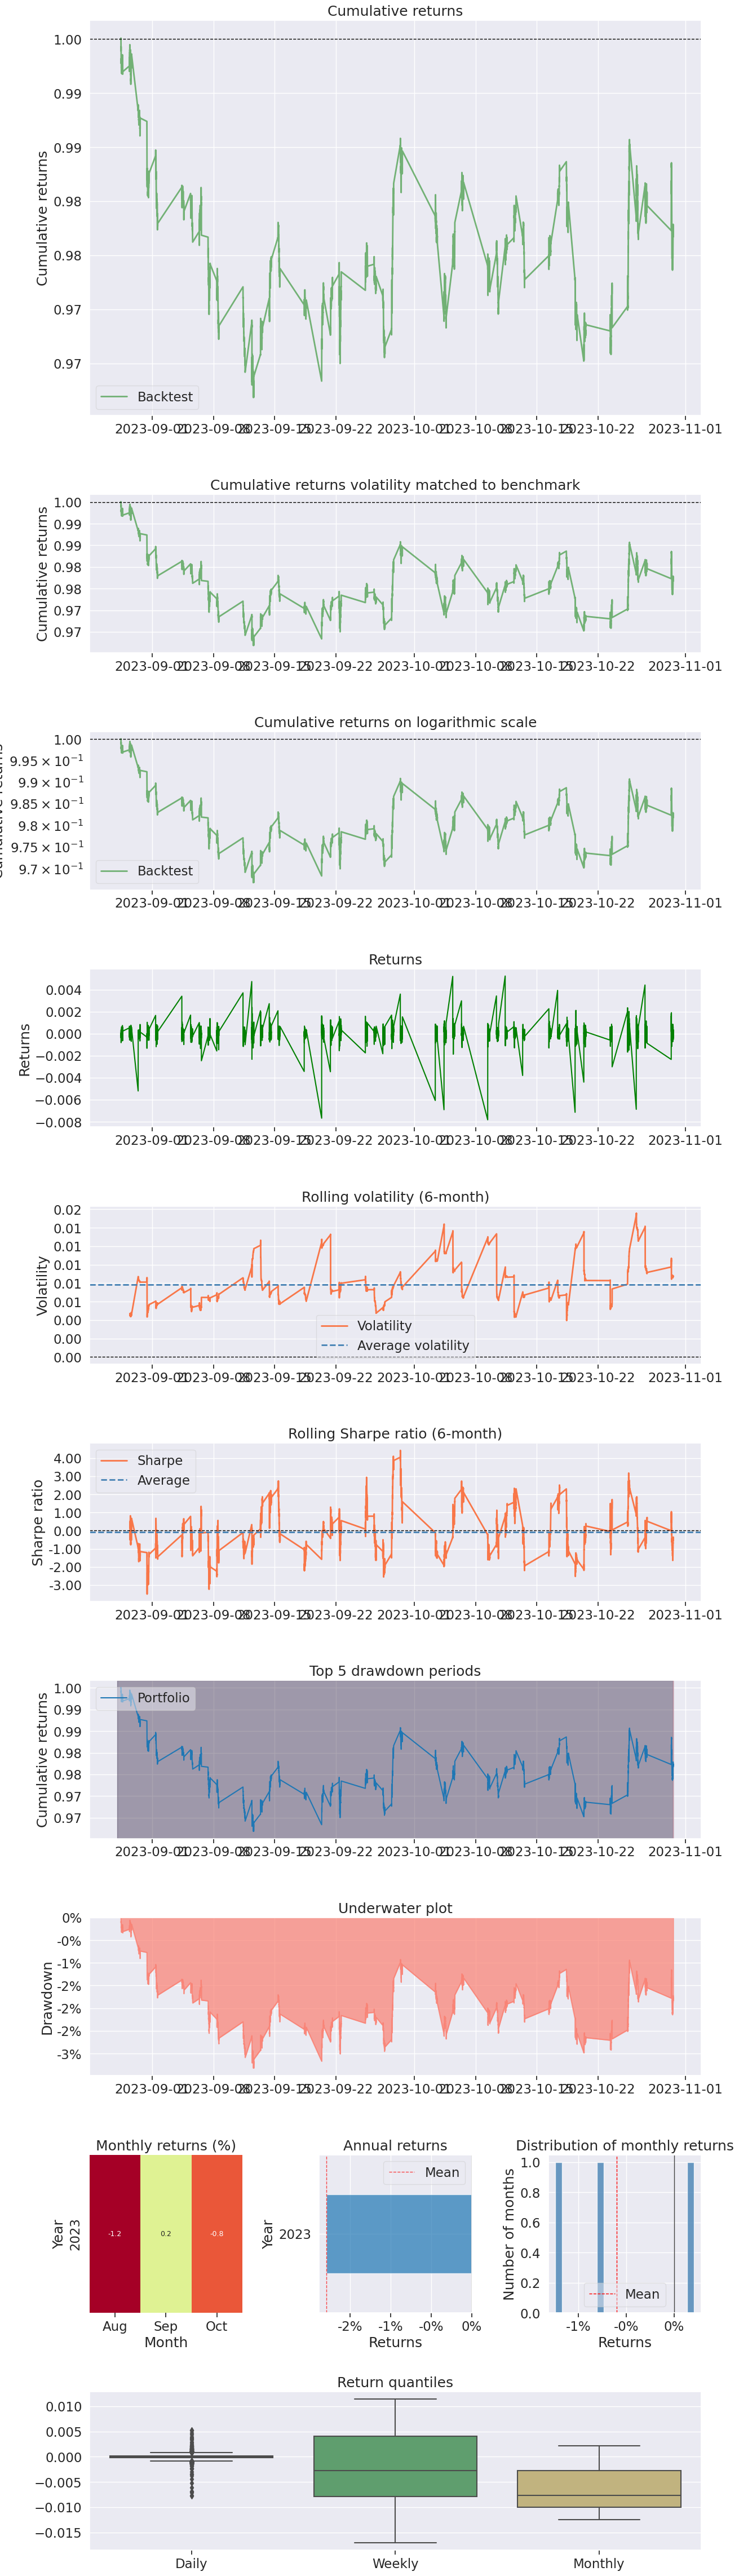

In [13]:
pf.create_full_tear_sheet(df['Returns'])

In [14]:
df.head()
df.tail()

,symbol,open,high,low,close,Effective Potential,Signal,Returns,Cumulative Returns
datetime,,,,,,,,,
2023-08-28 09:15:00,NSE:NIFTY,19306.75,19328.00,19295.65,19310.20,731.026406,NaN,NaN,NaN
2023-08-28 09:18:00,NSE:NIFTY,19310.80,19312.95,19275.05,19280.30,2734.418403,NaN,NaN,NaN
2023-08-28 09:21:00,NSE:NIFTY,19280.35,19280.35,19256.85,19274.75,178.000069,NaN,NaN,NaN
2023-08-28 09:24:00,NSE:NIFTY,19274.45,19278.45,19265.20,19266.00,345.185434,NaN,NaN,NaN
2023-08-28 09:27:00,NSE:NIFTY,19265.90,19273.15,19264.90,19269.60,46.865434,NaN,NaN,NaN


,symbol,open,high,low,close,Effective Potential,Signal,Returns,Cumulative Returns
datetime,,,,,,,,,
2023-10-30 14:48:00,NSE:NIFTY,19123.75,19134.90,19122.85,19134.80,46.183351,-1.0,-0.000539,-0.017811
2023-10-30 14:51:00,NSE:NIFTY,19133.80,19135.15,19125.40,19131.95,39.114601,-1.0,0.000149,-0.017662
2023-10-30 14:54:00,NSE:NIFTY,19130.65,19132.05,19123.85,19125.00,120.633611,1.0,0.000363,-0.017299
2023-10-30 14:57:00,NSE:NIFTY,19125.55,19129.80,19121.05,19129.80,12.990017,-1.0,0.000251,-0.017048
2023-10-30 15:00:00,NSE:NIFTY,19128.65,19137.10,19125.30,19137.10,33.254444,-1.0,-0.000382,-0.017430
